# Init

In [27]:
# Import utils
import numpy as np
import pandas as pd
import math
import time
import json
import pyreadr
import pickle
from joblib import dump, load
import random
import string
import os
import copy
import datetime
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Data-Driven Patient Scheduling modules
from DataDrivenPatientScheduling.WeightsModel import WeightsModel
from DataDrivenPatientScheduling.Experiment import Experiment

In [5]:
# Initialize expriment
experiment = Experiment()
path_data = '/home/fesc/dddex/PatientScheduling/Data'

# Load clean data

In [6]:
# Load
data = pd.read_csv(path_data+'/data.csv', sep=',')

# Simple EDA

In [7]:
# See "size" of areas
data.groupby('area').agg({'patient_id': len})

,patient_id
area,
area_8UduDpTP2BLDxVOB,514
area_C0VtRGF2J4sEV92m,4039
area_CBvUQGuiAXmGi85Q,1706
area_KOrhl5uhoDxIehbr,551
area_zKhklJm4RNBoA8Tg,568


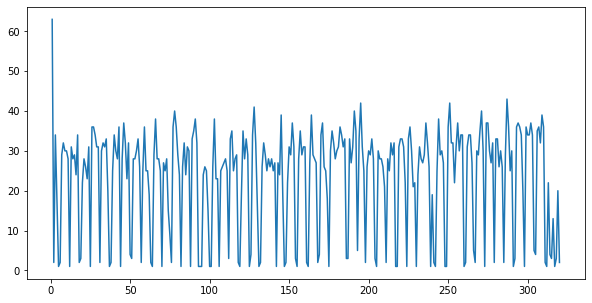

In [8]:
# Number of cases per day
plotData = data.groupby(['date']).agg(M=('patient_id', len)).reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
p = ax.plot(plotData['date'], plotData['M'])

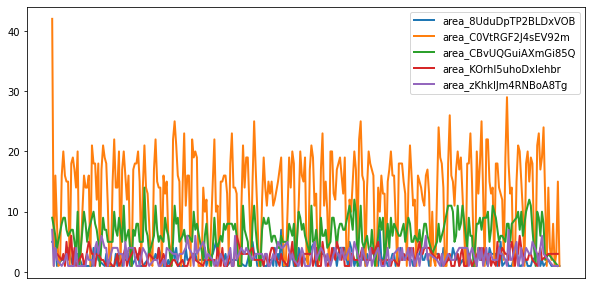

In [9]:
# Number of cases per day by area
plotData = data.groupby(['date', 'area']).agg(M=('patient_id', len)).reset_index().groupby('area')

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

for area, d in plotData:
    ax.plot(d['date'], d.M, marker='', linestyle='-', ms=2, linewidth=2, label=area)
ax.legend()
ax.get_xaxis().set_visible(False)
plt.show()

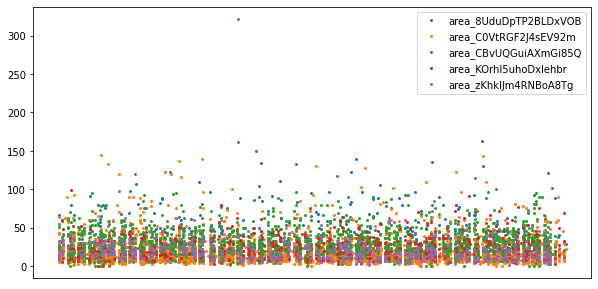

In [10]:
# Duration by area
plotData = data.groupby('area')

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

for area, d in plotData:
    ax.plot(d['date'], d['duration'], marker='o', linestyle='', ms=2, label=area)
ax.legend()
ax.get_xaxis().set_visible(False)
plt.show()

In [11]:
# Average number of cases and case duration per day by area
data.groupby(['date', 'area']).agg(
    n_cases=('patient_id', len),
    duration=('duration', np.mean),
).groupby('area').agg(
    n_cases=('n_cases', np.mean),
    duration=('duration', np.mean)
).reset_index()

,area,n_cases,duration
0,area_8UduDpTP2BLDxVOB,2.284444,41.958910
1,area_C0VtRGF2J4sEV92m,12.904153,19.134803
2,area_CBvUQGuiAXmGi85Q,6.638132,31.293970
3,area_KOrhl5uhoDxIehbr,2.448889,25.830593
4,area_zKhklJm4RNBoA8Tg,2.730769,20.371909


# Select data for training and testing

In [12]:
# Select a split for training and testing
sel = data.groupby(['date']).agg(
    n_cases=('patient_id', len)
).reset_index().sort_values(by='date')

sel['n_cases'] = sel.n_cases.cumsum()

sel['percent_cases'] = sel.n_cases / max(sel.n_cases)

# Split at
share_train = 0.80

test_start_date = min(sel.loc[sel.percent_cases > share_train].date)

test_start_date

257

In [13]:
# Add identifier for train vs test data
data['train_test'] = ''
data.loc[data.date < test_start_date, 'train_test'] = 'train'
data.loc[data.date >= test_start_date, 'train_test'] = 'test'

In [14]:
# Inspect train-test split
train_test = data.groupby(['train_test', 'date']).agg(
    n_cases=('patient_id', len)
).reset_index().groupby('train_test').agg(
    n_cases=('n_cases', sum),
    n_days=('date', len)
).reset_index()

train_test['percent_cases'] = np.around(train_test['n_cases'] / sum(train_test['n_cases']) * 100, 1)
train_test['percent_days'] = np.around(train_test['n_days'] / sum(train_test['n_days']) * 100, 1)

train_test

,train_test,n_cases,n_days,percent_cases,percent_days
0,test,1478,64,20.0,20.0
1,train,5900,256,80.0,80.0


# Adding new features on surgeons and assistants

In [15]:
# All surgeons
surgeons = [col for col in data.columns if 'surgeon_' in col]

# All assistants
assistants = [col for col in data.columns if 'assistant_' in col]

## Team setup

In [16]:
# Number of surgeons
data['n_surgeons'] = data[surgeons].sum(axis=1)

# Number of assistants
data['n_assistants'] = data[surgeons].sum(axis=1)

# Total team size
data['team_size'] = data['n_surgeons'] + data['n_assistants']

## Team experience

In [17]:
# Number of cases per surgeon, assistant, team (in-sample)
surgeons_experience = data.loc[data.train_test == 'train', surgeons].sum(axis=0)
assistants_experience = data.loc[data.train_test == 'train', assistants].sum(axis=0)
team_experience = data.loc[data.train_test == 'train', surgeons+assistants].sum(axis=0)

# Average surgeon experience
data['surgeons_experience'] = data.apply(

    lambda df: sum(surgeons_experience[(df[surgeons] == 1)]) / 
        df['n_surgeons'] if df['n_surgeons'] > 0 else 0, axis=1
    
)

# Average assistant experience
data['assistants_experience'] = data.apply(

    lambda df: sum(assistants_experience[(df[assistants] == 1)]) / 
        df['n_assistants'] if df['n_assistants'] > 0 else 0, axis=1
    
)

# Average team experience
data['team_experience'] = data.apply(

    lambda df: sum(team_experience[(df[surgeons + assistants] == 1)]) / 
        df['team_size'] if df['team_size'] > 0 else 0, axis=1
    
)

# Room assignments

Room assignment ...

In [18]:
experiment = Experiment()

## (A) Per area

Each area is assigned exactly one room, independent of any room capacity constraints.

In [19]:
# Room assignment
room_assignments_xArea = experiment.room_assignment(data, max_rooms=1, max_room_capacity=np.inf,
                                                    room_utilization=1, by_area=True)

## (B) Capacity based

Capacity based room assignments independent of areas and without limiting the number of rooms.

In [20]:
# Room assignment
room_assignments_xCapacity = experiment.room_assignment(data, max_rooms=np.inf, max_room_capacity=None,
                                                        room_utilization=1, by_area=False)

## (C) Capacity based per area

Capacity based room assignment for each area without limiting the number of rooms.

In [21]:
# Room assignment
room_assignments_xCapacity_xArea = experiment.room_assignment(data, max_rooms=np.inf, max_room_capacity=None, 
                                                              room_utilization=1, by_area=True)

# Finalize and save

In [22]:
# These columns will be used as identifiers
identifiers = ['date', 'area', 'patient_id', 'train_test']

In [23]:
# Response
y_data = data['duration']

In [24]:
# Features
X_data = data.drop(['duration']+identifiers, axis=1)

In [25]:
# Identifiers
ID_data = data[identifiers]

In [26]:
# Save
y_data.to_csv(path_data+'/y_data.csv', sep=',', index=False)
X_data.to_csv(path_data+'/X_data.csv', sep=',', index=False)
ID_data.to_csv(path_data+'/ID_data.csv', sep=',', index=False)
room_assignments_xArea.to_csv(path_data+'/room_assignments_xArea.csv', sep=',', index=False)
room_assignments_xCapacity.to_csv(path_data+'/room_assignments_xCapacity.csv', sep=',', index=False)
room_assignments_xCapacity_xArea.to_csv(path_data+'/room_assignments_xCapacity_xArea.csv', sep=',', index=False)